In [ ]:
import os
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from matplotlib import patches
import gdown
import tarfile
import seaborn as sns
import pandas as pd
import torch
from PIL import Image

In [ ]:
url = 'https://drive.google.com/uc?id=1GsC6vtBm47kNUPrCU-8_hXU1Pi0BraE9'
output = '/content/train.tar'
gdown.download(url, output, quiet=False)
tf = tarfile.open(output)
tf.extractall('/content/')

url = 'https://drive.google.com/uc?id=1JVCAqZOhKCs3_5KrlZakB-ZJZTcyZSS3'
output = '/content/test.tar'
gdown.download(url, output, quiet=False)
tf = tarfile.open(output)
tf.extractall('/content/')

Downloading...
From: https://drive.google.com/uc?id=1GsC6vtBm47kNUPrCU-8_hXU1Pi0BraE9
To: /content/train.tar
295MB [00:04, 59.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JVCAqZOhKCs3_5KrlZakB-ZJZTcyZSS3
To: /content/test.tar
73.1MB [00:01, 68.8MB/s]


In [ ]:
def parse_images_and_bboxes(image_dir, load_img = False):
    """
    Parse a directory with images.
    :param image_dir: Path to directory with images.
    :return: A list with (filename, image_id, bbox, proper_mask) for every image in the image_dir.
    """
    example_filenames = os.listdir(image_dir)
    data = []
    image_sizes = list()
    for filename in example_filenames:
        image_id, bbox, proper_mask = filename.strip(".jpg").split("__")
        bbox = json.loads(bbox)
        cx, cy, w, h = bbox
        if w <= 0 or h <= 0:
          pass
            # print(image_id)
        proper_mask = True if proper_mask.lower() == "true" else False
        if load_img:
          image = Image.open(os.path.join(image_dir,filename)).convert('RGB')
          data.append((filename, image_id, bbox, proper_mask,
                ([image.width, image.height, image.width, image.height])))
        else:
          data.append((filename, image_id, bbox, proper_mask))
    return data

In [ ]:
def show_images_and_bboxes(data, image_dir, specific_filename = None):
    """
    Plot images with bounding boxes. Predicts random bounding boxes and computes IoU.
    :param data: Iterable with (filename, image_id, bbox, proper_mask) structure.
    :param image_dir: Path to directory with images.
    :return: None
    """
    import random
    smaller_data = random.choices(data, k=20)
    for filename, image_id, bbox, proper_mask in smaller_data:
        # if filename[0:6] not in specific_filename and specific_filename:
        #   continue
        # Load image
        im = cv2.imread(os.path.join(image_dir, filename))
        # BGR to RGB
        im = im[:, :, ::-1]
        # image = Image.open(os.path.join(image_dir,filename)).convert('RGB')
        # print(image.width, image.height)
        # Ground truth bbox
        x1, y1, w1, h1 = bbox
        print(bbox)
        # box = [x1, y1, x1 + w1, y1 + h1]
        # print(box)
        # Plot image and bboxes
        fig, ax = plt.subplots()
        ax.imshow(im)
        rect = patches.Rectangle((x1, y1), w1, h1,
                                 linewidth=2, edgecolor='g', facecolor='none', label='ground-truth')
        ax.add_patch(rect)
        fig.suptitle(f"proper_mask={proper_mask}")
        ax.axis('off')
        fig.legend()
        plt.show()

[64, 62, 46, 43]


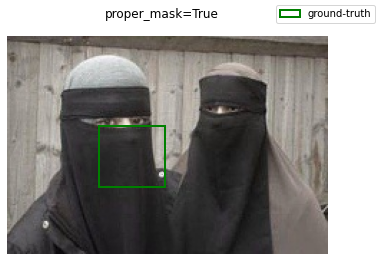

[70, 107, 96, 96]


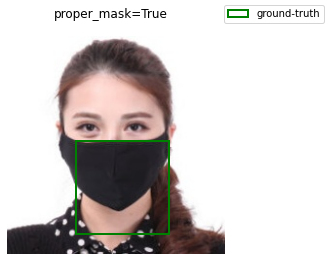

[99, 62, 60, 56]


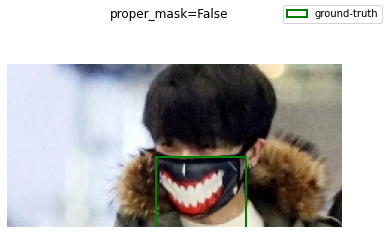

[21, 145, 65, 67]


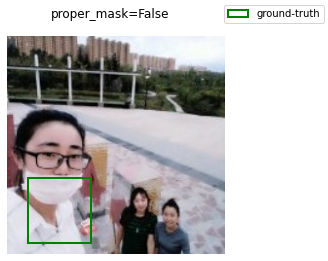

[67, 44, 99, 91]


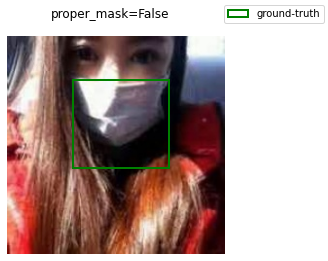

[65, 84, 93, 102]


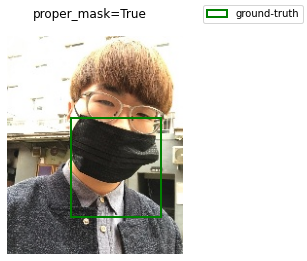

[65, 75, 20, 21]


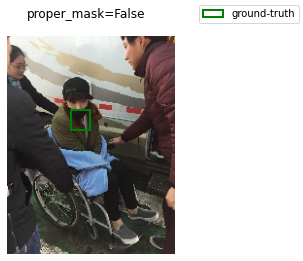

[42, 78, 66, 68]


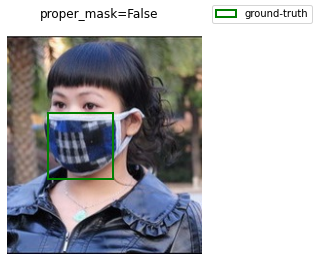

[104, 133, 72, 84]


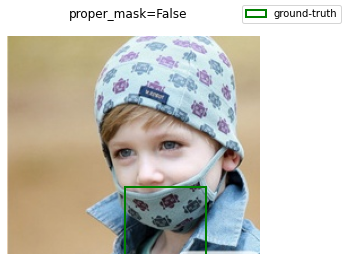

[19, 64, 126, 131]


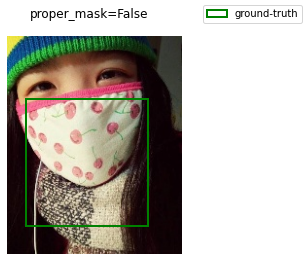

[64, 119, 54, 49]


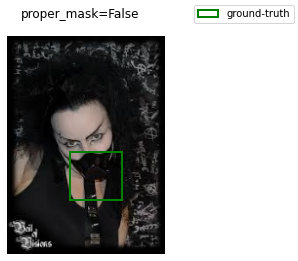

[82, 45, 73, 75]


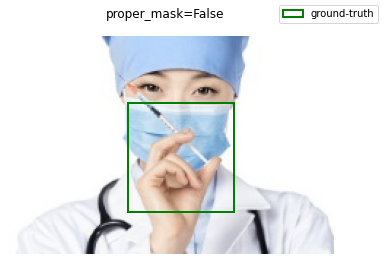

[77, 104, 125, 94]


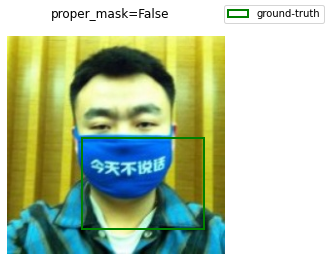

[125, 65, 88, 104]


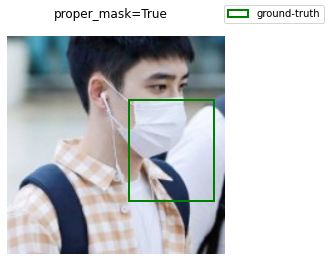

[156, 84, 80, 84]


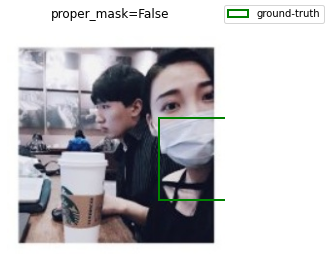

[36, 78, 52, 54]


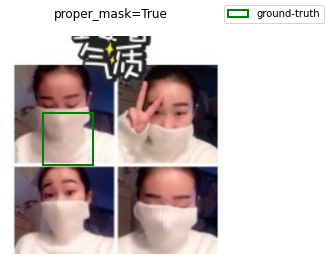

[29, 48, 33, 41]


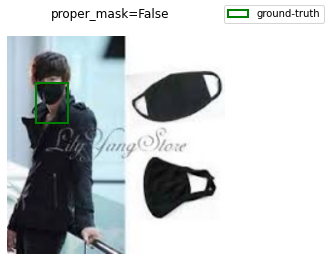

[77, 95, 110, 109]


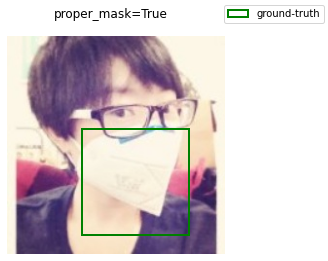

[100, 69, 97, 112]


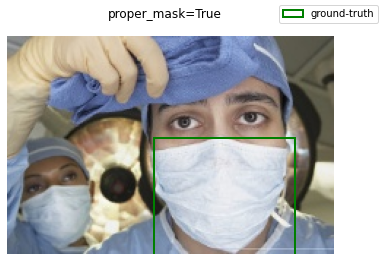

[32, 109, 91, 80]


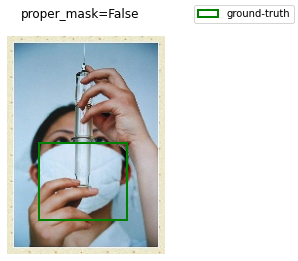

In [ ]:
image_dir = "train"
data = parse_images_and_bboxes(image_dir)
show_images_and_bboxes(data, image_dir)

### Calculate boxes AVG size

In [ ]:
def calculate_mean_box_size(data, image_dir):
  box_size = list()
  for filename, image_id, bbox, proper_mask in data:
    # Load image
    im = cv2.imread(os.path.join(image_dir, filename))
    # BGR to RGB
    im = im[:, :, ::-1]
    h, w, _ = im.shape
    # Ground truth bbox
    x1, y1, w1, h1 = bbox
    precent = (w1*h1) / (h*w)
    box_size.append(precent)

  
  return box_size

In [ ]:
image_dir = "train"
data = parse_images_and_bboxes(image_dir)
train_box = calculate_mean_box_size(data, image_dir)

In [ ]:
image_dir = "test"
data = parse_images_and_bboxes(image_dir)
test_box = calculate_mean_box_size(data, image_dir)


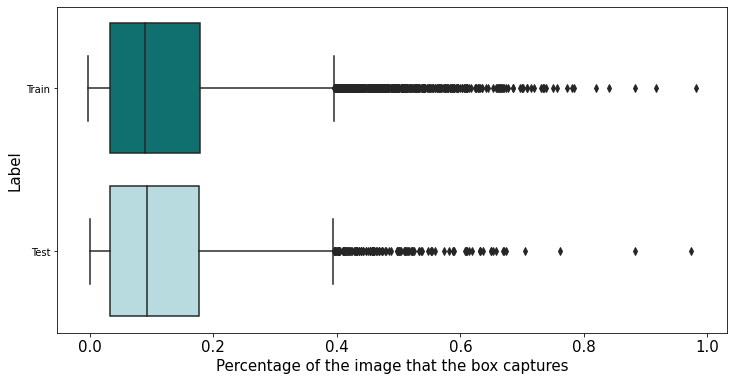

In [ ]:
box = train_box+ test_box
label = ['Train']*len(train_box) + ['Test']*len(test_box)

data = {'Size': box, 'Label': label}
df = pd.DataFrame(data)

fig = plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Size', data=df, y='Label' ,palette=['teal', 'powderblue'])
plt.xlabel("Percentage of the image that the box captures",fontdict={'fontsize':15})
plt.xticks(fontsize=15)
plt.ylabel("Label",fontdict={'fontsize':15})
plt.show()


### Calculate Lable distribution

In [ ]:
def lable_distribution(data, image_dir):
  lable_lst = list()
  for filename, image_id, bbox, proper_mask in data:
    # Load image
    lable= filename.split('__')[2][:-4]
    lable_lst.append(lable)  
  f_count = lable_lst.count('False')
  t_count = lable_lst.count('True')
  fig = plt.figure(figsize=(6,6))
  ax = sns.countplot(lable_lst, order=['True','False'], palette=['olivedrab','firebrick'])
  ax.text(0.85,f_count,f'{int(np.round(f_count/len(lable_lst) *100))}%', fontsize=15)
  ax.text(-0.1,t_count,f'{int(np.round(t_count/len(lable_lst) *100))}%', fontsize=15)
  plt.xlabel("IMG Label",fontdict={'fontsize':15})
  plt.xticks(fontsize=15)
  plt.ylabel("Number of IMG",fontdict={'fontsize':15})

  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


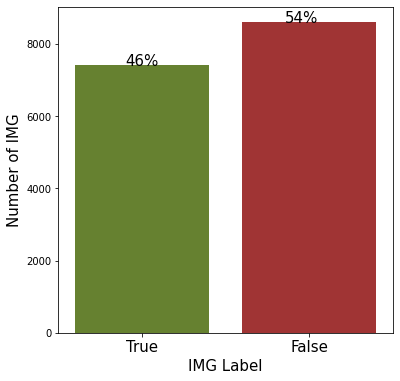

In [ ]:
image_dir = "train"
data = parse_images_and_bboxes(image_dir)
lable_distribution(data, image_dir)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


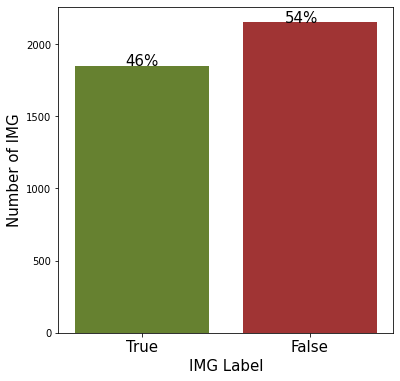

In [ ]:
image_dir = "test"
data = parse_images_and_bboxes(image_dir)
lable_distribution(data, image_dir)

### Find for each region of the image, what is the percentage of bounding boxes that are in this region

In [ ]:
def box_main_loc_dist(data,image_dir):
  cnt = 0
  item_top_left, item_top_right, item_bottom_left, item_bottom_right = 0,0,0,0
  for idx, item in enumerate(data):
    tl, tr, bl, br = False,False,False,False
    cx, cy, w, h = item[2]
    bbox = [cx, cy, cx + w, cy + h]
    res = [i / j for i, j in zip(bbox, item[4])]
    # if bbox[0] <0 or bbox[1] <0 or  bbox[0] > item[4][0] or  bbox[1] > item[4][1]:
    #   print(bbox, item[4])
    #   show_images_and_bboxes(data, image_dir, specific_filename = item[0])
    for r in res:
      if r > 1:
        # print(bbox, item[4])
        # show_images_and_bboxes(data, image_dir, specific_filename = item[0])
        cnt+=1
    bbox = [(res[0],res[1]),(res[2],res[1]),(res[0],res[3]),(res[2],res[3])]
    locs = ['tl', 'tr', 'bl', 'br']
    size = 0
    chosen_loc = None
    for b_item, loc in zip(bbox,locs):
      tmp_size = np.abs(0.5-b_item[0]) * np.abs(0.5-b_item[1])
      if tmp_size > size:
        size = tmp_size
        chosen_loc = loc
    if chosen_loc == 'tl':
      item_top_left += 1
    elif chosen_loc == 'tr':
      item_top_right += 1
    elif chosen_loc == 'bl':
      item_bottom_left += 1
    elif chosen_loc == 'br':
      item_bottom_right += 1

  print('cntttt', cnt)
  fig = plt.figure(figsize=(10,6))
  ax = sns.barplot(x=['Top Left', 'Top Right', 'Bottom Left', 'Bottom Right'], y=[item_top_left, item_top_right, item_bottom_left, item_bottom_right], palette=['tomato','tan','cornflowerblue','mediumaquamarine'])
  ax.text(-0.1,item_top_left,f'{int(np.round(item_top_left/len(data) *100))}%', fontsize=15)
  ax.text(0.85,item_top_right,f'{int(np.round(item_top_right/len(data) *100))}%', fontsize=15)
  ax.text(1.85,item_bottom_left,f'{int(np.round(item_bottom_left/len(data) *100))}%', fontsize=15)
  ax.text(2.85,item_bottom_right,f'{int(np.round(item_bottom_right/len(data) *100))}%', fontsize=15)
  plt.xlabel("location of bounding box in the image", fontsize=15)
  plt.xticks(fontsize=15)
  plt.ylabel("Number of IMG", fontsize=15)

  plt.show()

cntttt 2179


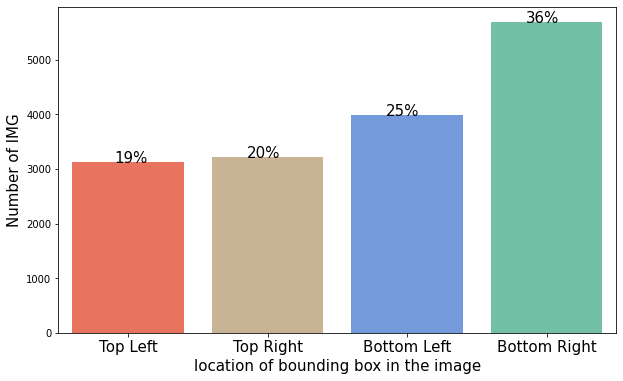

In [ ]:
image_dir = "train"
data = parse_images_and_bboxes(image_dir,load_img=True)
box_main_loc_dist(data,image_dir)

cntttt 557


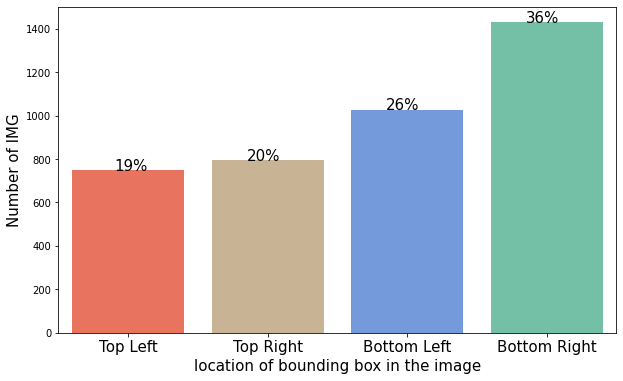

In [ ]:
image_dir = "test"
data = parse_images_and_bboxes(image_dir,load_img=True)
box_main_loc_dist(data,image_dir)

plot loss, accuracy, iou- resnet34 basic approach


In [ ]:

train_iou= [0.1866485777293094, 0.2575558731477406, 0.2810454374978521, 0.3515247212228686, 0.42044270443880044, 0.4716372370493684, 0.49654952505730826, 0.5183521170209988, 0.5311962093299407, 0.5478867216900778, 0.5604242972862117, 0.570588184196795, 0.5769266961414247, 0.5890326623516918, 0.5910950058590765, 0.6010506515966105, 0.6052072808124729, 0.6114509305181571, 0.6162420369554974, 0.621502793063405, 0.6252836607487704, 0.6301613579028718, 0.6374013930190678, 0.6427525700790717, 0.6469263489511431, 0.649792084320493, 0.6541718010756632, 0.656259536340619, 0.6595347422802534, 0.6592496128489985, 0.6693354170923652, 0.6736228661528278, 0.6752283204827751, 0.6756346087329972, 0.6821801226047786, 0.6853557487930313, 0.6809483134242076, 0.689761284247458, 0.696102784325456, 0.6904432425054317, 0.6978960514050905, 0.7077812693525014, 0.7006777569534599, 0.6999519729010228, 0.7113040633667991, 0.7145076985349929, 0.713313629735487, 0.7196856449809097, 0.7079918642014416, 0.7156640466422359]
train_accuracy= [0.5219728699131088, 0.5365381008939176, 0.5369756829405513, 0.5528536600612615, 0.5719822466712509, 0.5929861849096706, 0.6078014627742702, 0.6190535725448522, 0.6290554478964806, 0.6403075576670626, 0.6490591985997375, 0.6494967806463712, 0.6706882540476339, 0.6726886291179596, 0.6820653872601112, 0.6957554541476527, 0.7045070950803276, 0.7162592986184909, 0.7260111270863286, 0.7277614552728636, 0.7400137525786085, 0.7501406513721323, 0.7634556479339876, 0.769394261424017, 0.7787710195661687, 0.7852097268237794, 0.790335687941489, 0.7957116959429893, 0.8054010126898794, 0.8101519034819028, 0.8254047633931362, 0.8229668062761768, 0.8385947365130962, 0.8447833968869163, 0.8549728074013878, 0.8652872413577546, 0.8728511595924235, 0.8907920235044071, 0.8965431018315935, 0.9126086141151466, 0.9225479777458273, 0.9332999937488279, 0.9369256735637932, 0.9495530411952241, 0.9539288616615615, 0.9616803150590736, 0.9712446083640682, 0.9707445145964868, 0.9770581984122023, 0.981183971994749]
train_loss= [0.5120676685334922, 0.39134315044319373, 0.34332880240839375, 0.2576920563052235, 0.20896291986155333, 0.1790925411833162, 0.16531078706810368, 0.15404166762155316, 0.14703011126743895, 0.13917264382735023, 0.13252436018529634, 0.12887522404794657, 0.1252865141806412, 0.11958531852870492, 0.11718267257894555, 0.11279151978742825, 0.11025025420258357, 0.10681994393399905, 0.10578605643866948, 0.10259810115215427, 0.10049947568861597, 0.09807858321341364, 0.09458591279711076, 0.0928387635945156, 0.09128036193194267, 0.08859368041879633, 0.08686135923623249, 0.08554982104703561, 0.08413175088789804, 0.08368340699294287, 0.08047552897780062, 0.07937967374100197, 0.07692054826751116, 0.07648878031360616, 0.07351813195921253, 0.0729557414900521, 0.07322656617221544, 0.07095351308302901, 0.06881184362430695, 0.06978860643347137, 0.066912547717983, 0.06496383852158932, 0.06616273042283341, 0.06545996950620143, 0.06206714837947711, 0.06090464451584718, 0.061099455894183585, 0.05840633023848584, 0.06136268420898148, 0.05865477107201188]
test_iou= [0.21042761552764933, 0.24857194831539983, 0.30521706443699076, 0.32479665020792164, 0.42138440063542293, 0.4715862220099261, 0.46276624491864643, 0.527551900235776, 0.5354999768011912, 0.5422218749790846, 0.5588358956563825, 0.5270920174768944, 0.5603540870957149, 0.5918277174048708, 0.5686007758835622, 0.44807411920282175, 0.5565600484785901, 0.6042568020186391, 0.606038870571705, 0.6130013445141376, 0.5900323226954679, 0.5942646466583811, 0.5571480950709119, 0.610964428172534, 0.5822125694099918, 0.6157239285627293, 0.599720272338629, 0.623703619172651, 0.6016179170294126, 0.6321424201033369, 0.5952477391548818, 0.6229606952147442, 0.5857046709593705, 0.6208523139722237, 0.6226864966069988, 0.6237943412725144, 0.6160909293950826, 0.6327156779870856, 0.5883228300141636, 0.5680991778984098, 0.6272604877747362, 0.6258450264818821, 0.6100317166768072, 0.5933412170402423, 0.5907243289432227, 0.615943686555147, 0.6174884277087404, 0.6258040359420848, 0.5939655692214365, 0.6211259684008109]
test_accuracy= [0.5375, 0.502, 0.5435, 0.5775, 0.56475, 0.492, 0.59275, 0.61925, 0.60175, 0.63775, 0.59925, 0.59175, 0.65525, 0.662, 0.6475, 0.581, 0.66975, 0.69125, 0.58775, 0.559, 0.70325, 0.74175, 0.72975, 0.737, 0.7475, 0.75225, 0.74525, 0.762, 0.7155, 0.71025, 0.6395, 0.75725, 0.75275, 0.72925, 0.69025, 0.73775, 0.7115, 0.751, 0.73725, 0.6785, 0.7485, 0.7275, 0.63425, 0.73, 0.75125, 0.74225, 0.73425, 0.755, 0.7315, 0.69125]
test_loss= [0.443769579410553, 0.45076842832565306, 0.3024560708999634, 0.24628722453117372, 0.21158723735809326, 0.19147740745544434, 0.17622019624710084, 0.15359541046619415, 0.15049311697483062, 0.14433099043369294, 0.1403491997718811, 0.14914112424850465, 0.1405705635547638, 0.12939272701740265, 0.13428024089336396, 0.1546524360179901, 0.1306787897348404, 0.1235605661869049, 0.1235344945192337, 0.1253871041536331, 0.1279296612739563, 0.12207760572433472, 0.1324330370426178, 0.12168192112445832, 0.12417078232765198, 0.12021967911720276, 0.12378870141506194, 0.11715560388565063, 0.12500339591503143, 0.11362939560413361, 0.13120561158657074, 0.11722202563285827, 0.12531417679786683, 0.11550827312469482, 0.11783355391025543, 0.11839753556251525, 0.12120597279071808, 0.1151934916973114, 0.12986455345153808, 0.12937337732315063, 0.11564177119731903, 0.11785272443294526, 0.1232787789106369, 0.1235541535615921, 0.12913277602195739, 0.11829478120803832, 0.11758624410629273, 0.11726148700714112, 0.120920236825943, 0.12235691511631012]


In [ ]:
list_idx = list(range(len(test_iou)))
fig = px.line(x = list_idx, y=test_iou)
fig.show()

In [ ]:
chosen_idx = 27

In [ ]:
def combine_data(train_list,test_list):
  train_list =train_list[:40]
  test_list = test_list[:40]
  list_idx = list(range(len(train_list)))
  train_df = pd.DataFrame(columns=['split','epoch','value'])
  train_df['epoch'] = list_idx
  train_df['value'] = train_list
  train_df['split'] = 'train'

  test_df = pd.DataFrame(columns=['split','epoch','value'])
  test_df['epoch'] = list_idx
  test_df['value'] = test_list
  test_df['split'] = 'test'

  tot_df = pd.concat((train_df,test_df))
  return tot_df

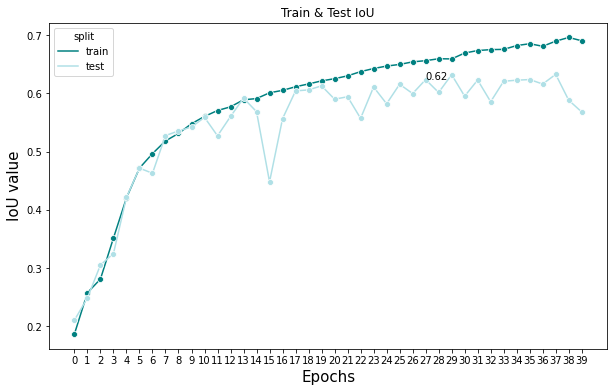

In [ ]:
iou_df = combine_data(train_iou,test_iou)
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=iou_df['epoch'], y=iou_df['value'],hue=iou_df['split'],marker='o',palette=['teal', 'powderblue'])
ax.text(chosen_idx,test_iou[chosen_idx],f'{np.round(test_iou[chosen_idx],2)}', fontsize=10)
plt.xlabel("Epochs", fontsize=15)
plt.xticks(list(range(int(len(iou_df)/2))))
plt.ylabel("IoU value", fontsize=15)
plt.title('Train & Test IoU')
plt.show()

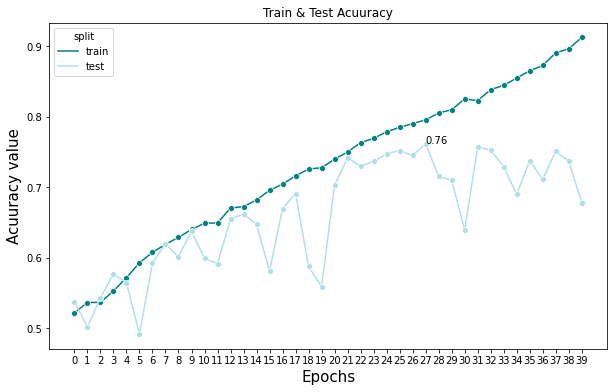

In [ ]:
iou_df = combine_data(train_accuracy,test_accuracy)
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=iou_df['epoch'], y=iou_df['value'],hue=iou_df['split'],marker='o',palette=['teal', 'powderblue'])
ax.text(chosen_idx,test_accuracy[chosen_idx],f'{np.round(test_accuracy[chosen_idx],2)}', fontsize=10)
plt.xlabel("Epochs", fontsize=15)
plt.xticks(list(range(int(len(iou_df)/2))))
plt.ylabel("Acuuracy value", fontsize=15)
plt.title('Train & Test Acuuracy')
plt.show()

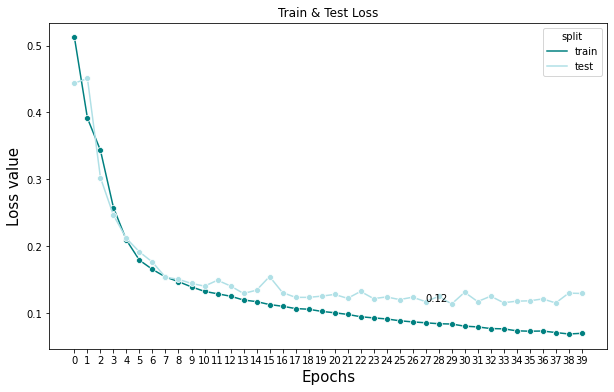

In [ ]:
iou_df = combine_data(train_loss,test_loss)
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=iou_df['epoch'], y=iou_df['value'],hue=iou_df['split'],marker='o',palette=['teal', 'powderblue'])
ax.text(chosen_idx,test_loss[chosen_idx],f'{np.round(test_loss[chosen_idx],2)}', fontsize=10)
plt.xlabel("Epochs", fontsize=15)
plt.xticks(list(range(int(len(iou_df)/2))))
plt.ylabel("Loss value", fontsize=15)
plt.title('Train & Test Loss')
plt.show()

code for checking .csv result file
